In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import (accuracy_score, classification_report, 
                           confusion_matrix, roc_auc_score, RocCurveDisplay)
from sklearn import tree
import graphviz

In [8]:
df = pd.read_csv('heart.csv')

In [10]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


In [12]:
df.shape

(1025, 14)

In [14]:
df.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

In [16]:

df = df.drop_duplicates()

In [18]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


In [20]:
df.shape

(302, 14)

In [22]:
df = pd.get_dummies(df, columns=['cp', 'restecg', 'slope', 'thal'], drop_first=True)

In [24]:
X = df.drop('target', axis=1)
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

In [26]:
base_dt = DecisionTreeClassifier(random_state=42)
base_dt.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [28]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1]
    
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.4f}")
    
    print("Classification Report:")
    print(classification_report(y_test, y_pred, digits=4))
    
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    
    print(f"\nROC AUC Score: {roc_auc_score(y_test, y_proba):.4f}")
    
    RocCurveDisplay.from_estimator(model, X_test, y_test)
    plt.title('ROC Curve')
    plt.show()
    
    return accuracy


Base Decision Tree Performance:
Accuracy: 0.7541
Classification Report:
              precision    recall  f1-score   support

           0     0.7600    0.6786    0.7170        28
           1     0.7500    0.8182    0.7826        33

    accuracy                         0.7541        61
   macro avg     0.7550    0.7484    0.7498        61
weighted avg     0.7546    0.7541    0.7525        61


Confusion Matrix:
[[19  9]
 [ 6 27]]

ROC AUC Score: 0.7484


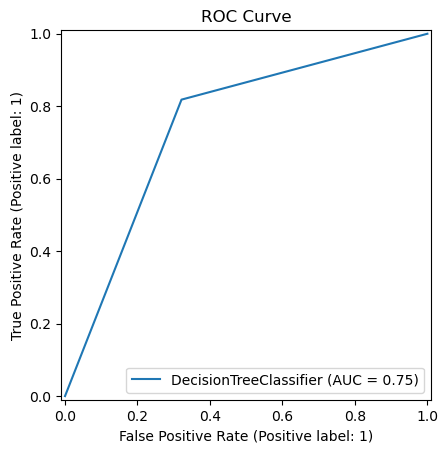

In [30]:
print("Base Decision Tree Performance:")
base_accuracy = evaluate_model(base_dt, X_test, y_test)

In [32]:
param_grid = {
    'max_depth': [None, 3, 5, 7, 10, 15],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'criterion': ['gini', 'entropy'],
}

In [34]:
grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42),
                          param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
best_dt = grid_search.best_estimator_


def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.4f}")
    
    print("Classification Report:")
    print(classification_report(y_test, y_pred, digits=4)) 
    
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    
    roc_auc = roc_auc_score(y_test, y_proba)
    print(f"\nROC AUC Score: {roc_auc:.4f}")
    
    RocCurveDisplay.from_estimator(model, X_test, y_test)
    plt.title('ROC Curve for Decision Tree')
    plt.savefig('roc_curve.png')
    plt.show()
    
    return accuracy


Tuned Decision Tree Performance:
Best Parameters: {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 8, 'min_samples_split': 2}
Accuracy: 0.7705
Classification Report:
              precision    recall  f1-score   support

           0     0.8500    0.6071    0.7083        28
           1     0.7317    0.9091    0.8108        33

    accuracy                         0.7705        61
   macro avg     0.7909    0.7581    0.7596        61
weighted avg     0.7860    0.7705    0.7638        61


Confusion Matrix:
[[17 11]
 [ 3 30]]

ROC AUC Score: 0.8019


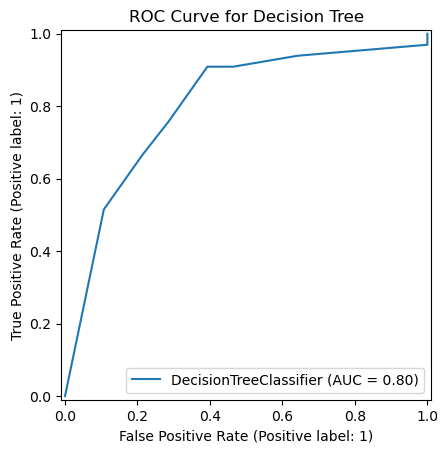

In [35]:
print("\nTuned Decision Tree Performance:")
print(f"Best Parameters: {grid_search.best_params_}")
best_accuracy = evaluate_model(best_dt, X_test, y_test)

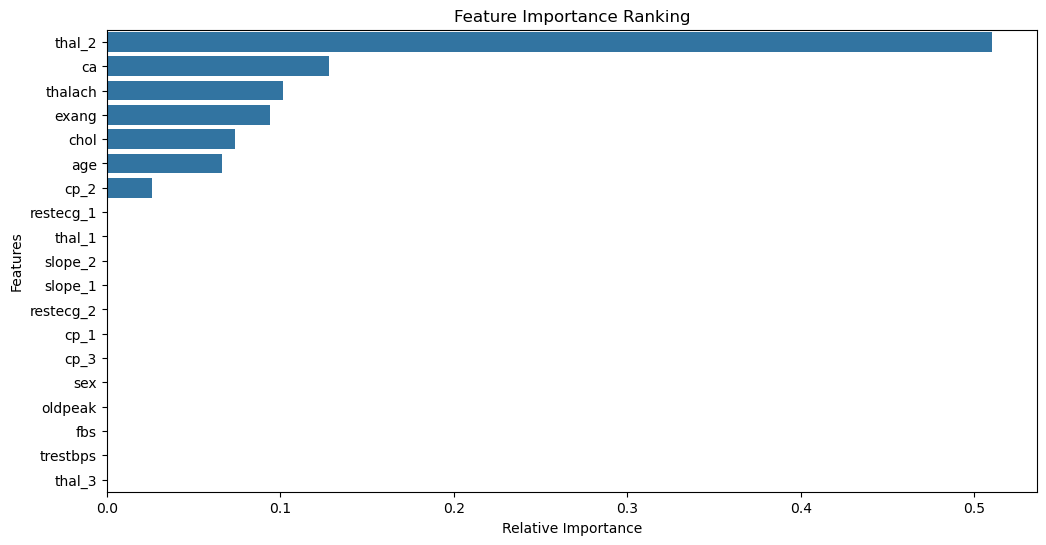

In [36]:
feature_imp = pd.Series(best_dt.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(12,6))
sns.barplot(x=feature_imp, y=feature_imp.index)
plt.title('Feature Importance Ranking')
plt.xlabel('Relative Importance')
plt.ylabel('Features')
plt.show()

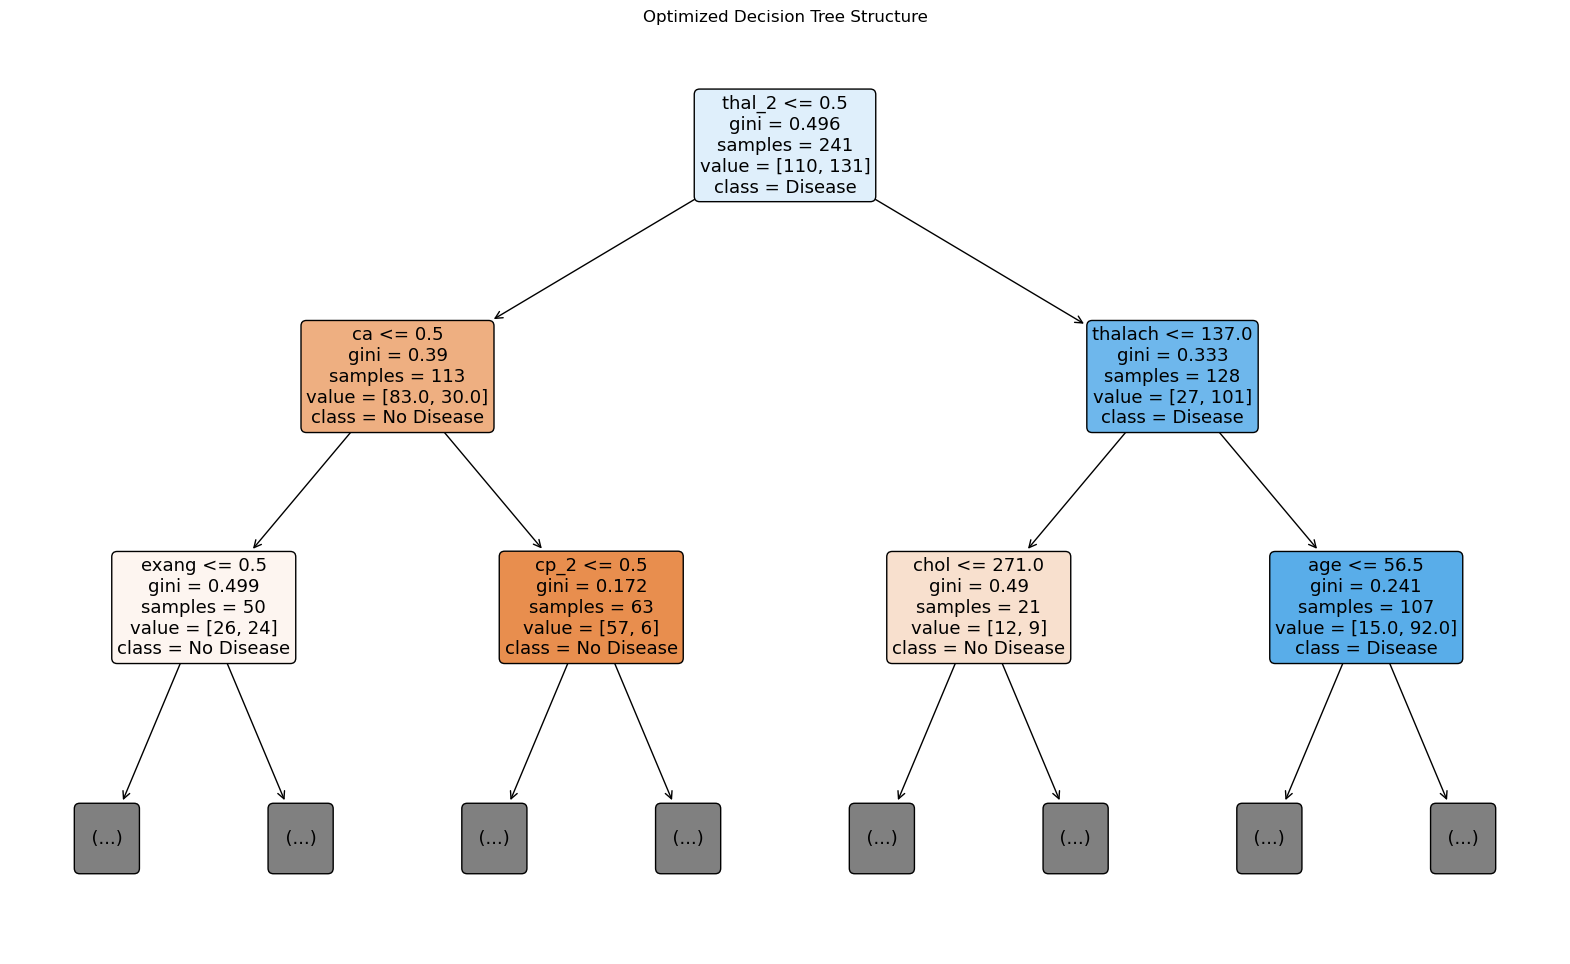

In [37]:

plt.figure(figsize=(20,12))
plot_tree(best_dt, 
          feature_names=X.columns, 
          class_names=['No Disease', 'Disease'],
          filled=True, 
          rounded=True,
          max_depth=2)
plt.title("Optimized Decision Tree Structure")
plt.savefig('tree.png')
plt.show()

In [50]:
def predict_heart_disease(model, new_data):
    missing_cols = set(X.columns) - set(new_data.columns)
    for col in missing_cols:
        new_data[col] = 0
    
    new_data = new_data[X.columns]
    
    prediction = model.predict(new_data)[0]
    probability = model.predict_proba(new_data)[0][1]
    
    result = "Disease" if prediction == 1 else "No Disease"
    
    return result, probability

In [52]:
new_patient_data = {
    'age': 65,
    'sex': 1,
    'trestbps': 142, 
    'chol': 228,      
    'fbs': 0,         
    'thalach': 140,   
    'exang': 1,       
    'oldpeak': 2.3,   
    'ca': 2               
}

In [54]:
# Create DataFrame for the new patient
new_patient = pd.DataFrame([new_patient_data])

In [56]:
for cat in ['cp', 'restecg', 'slope', 'thal']:
   
    cat_cols = [col for col in X.columns if col.startswith(f"{cat}_")]
    for col in cat_cols:
        new_patient[col] = 0 
    if cat == 'cp':
        new_patient['cp_1'] = 1  
    elif cat == 'restecg':
        new_patient['restecg_1'] = 1  
    elif cat == 'slope':
        new_patient['slope_1'] = 1 
    elif cat == 'thal':
        new_patient['thal_2'] = 1  

In [58]:
result, probability = predict_heart_disease(best_dt, new_patient)

print("\nPrediction for New Patient:")
print(f"Result: {result}")
print(f"Probability of Heart Disease: {probability:.4f}")


Prediction for New Patient:
Result: Disease
Probability of Heart Disease: 0.6571
